In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(data):
  scaler = MinMaxScaler()
  scaler.fit(data)
  return scaler.transform(data)


class NN:
  def __init__(self, X, y, hidden_layers=None, loss_function='mae', bias=0, validation_percent=.2, train=True):
    self.X = np.array(X)
    self.y = np.array(y)
    self.y = self.y.reshape(self.y.shape[0], 1)
    self.loss_function = loss_function
    self.bias = bias
    if hidden_layers:
      self.generate_layers(hidden_layers)
    if train:
      self.test_train_split(validation_percent)
    
    
  def test_train_split(self, validation_percent):
    if validation_percent >= 1:
      self.validation_percent //= 100
    self.validation_count = int(len(self.X) * validation_percent)
    indexes = np.array([i for i in range(len(self.X))])
    indexes = indexes[:self.validation_count]
    
    self.X_validation = self.X[indexes]
    self.y_validation = self.y[indexes]
    
    self.X = np.delete(self.X, indexes, axis=0)
    self.y = np.delete(self.y, indexes, axis=0)
      
  def generate_layers(self, hidden_layers):
    self.hidden_layers = hidden_layers
    np.random.seed(1)
    self.schema = [self.X.shape[1]] + hidden_layers + [self.y.shape[1]]
    self.schema_len = range(len(self.schema[:-1]))
    for i, layer in enumerate(self.schema[:-1]):
      setattr(self, f'W{i}', np.random.uniform(-1, 1, (layer, self.schema[i+1])))
      if i != len(self.schema_len) - 1:
        setattr(self, f'b{i}', np.full((1, self.schema[i+1]), self.bias))


  # sigmoid
  def nonlin(self, x, deriv=False):
    if(deriv==True):
      return x * (1 - x)
    return 1/ (1 + np.exp(-x))


  def forward(self, X=None):
    if str(X) == 'None':
      self.l0 = self.X
    else:
      self.l0 = np.array(X)
    for i in self.schema_len:
      l, W = (getattr(self, j) for j in f'l{i} W{i}'.split())
      if i != len(self.schema_len)-1:
        b = getattr(self, f'b{i}')
        setattr(self, f'l{i+1}', self.nonlin(l.dot(W) + b))
      else:
        setattr(self, f'l{i+1}', self.nonlin(l.dot(W)))
    return getattr(self, f'l{len(self.schema_len)}')


  def loss(self, error):
    loss_dict = {
      'mae': lambda x: np.mean(abs(x)),
      'mse': lambda x: np.mean(x**2),
      'hmse': lambda x: np.mean((x**2)*.5),
    }
    loss_function = loss_dict[self.loss_function]
    return loss_function(error)


  def backward(self, back_prop=True, validation=False):
    for i in reversed(self.schema_len):
      i += 1
      l = getattr(self, f'l{i}')
      if i == len(self.schema_len):
        if validation:
          error = self.y_validation - l
          self.validation_error = self.loss(error)
        else:
          error = self.y - l
          self.error = self.loss(error)
      else:
        delta, W = (getattr(self, j) for j in f'l{i}delta W{i}'.split())
        error = delta.dot(W.T)
      setattr(self, f'l{i-1}delta', error * self.nonlin(l, deriv=True))

    if back_prop: # adjust weights
      for i in reversed(self.schema_len):
        l, W, delta = (getattr(self, j) for j in f'l{i} W{i} l{i}delta'.split())
        delta = l.T.dot(delta)
        setattr(self, f'W{i}', W + delta)

  def validate(self):
    self.forward(self.X_validation)
    self.backward(back_prop=False, validation=True)
  

  def train(self, epochs=1000, print_nth_epoch=100):
    for j in range(epochs):
      self.forward()
      self.backward()
      if print_nth_epoch and not j % print_nth_epoch:
        self.validate()
        print(f'Test error: {round(self.error, 6)}\t Validation Error: {round(self.validation_error, 6)}')


  def predict(self, x):
    return self.forward(x)


  def genetic_alogrithm(self, population_size=30, mutation_rate=0.05, algorithm_epochs=30, nn_epochs=400):

    def make_new_generation(fitness):
      new_generation = []
      new_gen_labels = []
      for i in range(len(fitness)//2):
        parent = [int(j) for j in fitness[i][0].split()]
        child1 = [] # increment layers
        child2 = [] # decrement layers
        for layer_number in parent:
          if random.random() > mutation_rate: # change the number of neurons in each layer
            child1.append(layer_number + 1)
            if layer_number > 1:
              child2.append(layer_number - 1)
        if random.random() > mutation_rate: # add or remove a layer
          child1.append(random.choice(range(1,12)))
          if len(child2) > 2:
            child2.pop()
        for child in [child1, child2]:
          new_generation.append(child)
          new_gen_labels.append(str(child)[1:-1].replace(',', ''))
      return new_generation, new_gen_labels

    def create_initial_population():
      organisms = []
      organism_labels = []
      for i in range(population_size):
        organisms.append(np.random.choice(range(2,50), (random.choice(range(2,10)), )).tolist())
        organism_labels.append(str(organisms[i]).replace(',', '')[1:-1])
      return organisms, organism_labels

    def find_fitness(organisms, organism_labels):
      fitness = []
      for organism, organism_label in zip(organisms, organism_labels):
        self.generate_layers(organism)
        self.train(nn_epochs, None)
        fitness.append([organism_label, self.error])
      fitness = sorted(fitness, key=lambda x: x[1])
      fittest_list.append(fitness[0])
      return fitness

    fittest_list = [] # list of fittest organisms to be plotted.

    organisms, organism_labels = create_initial_population()
    fitness = find_fitness(organisms, organism_labels)

    for _ in range(algorithm_epochs):
      organisms, organism_labels = make_new_generation(fitness)
      fitness = find_fitness(organisms, organism_labels)

    self.x_labels = [label for label, x in fittest_list]
    self.x_fitness = [x for label, x in fittest_list]

    fig, ax = plt.subplots(figsize=(15,5))
    ax = plt.plot(self.x_fitness)
    plt.xticks(range(len(self.x_labels)), self.x_labels, rotation=90)
    plt.show()

  def find_best_bias(self, bias_range=np.arange(-5,5,.1), nn_epochs=400):
    score = []
    for i in bias_range:
      self.generate_layers(self.hidden_layers)
      self.bias = i
      self.train(nn_epochs, None)
      score.append(self.error)

    self.bias_score = list(sorted(zip(score, bias_range), key=lambda x: x[0]))
    self.bias_score_df = pd.DataFrame(nn.bias_score, columns=['Error', 'Bias'])

    fig, ax = plt.subplots(figsize=(15,5))
    plt.xticks([x for x in range(len(bias_range))[::2]], [str(round(x,2)) for x in bias_range[::2]], rotation=90)
    ax = plt.plot(score)
    plt.show()


In [8]:
nn1 = NN(X, y, [50, 100], loss_function='mae', bias=-4.2, validation_percent=.20)
nn1.train(2000, 250)

Test error: 0.284975	 Validation Error: 0.168546
Test error: 0.035949	 Validation Error: 0.044443
Test error: 0.038464	 Validation Error: 0.045025
Test error: 0.026052	 Validation Error: 0.029294
Test error: 0.029696	 Validation Error: 0.029288
Test error: 0.02522	 Validation Error: 0.028349
Test error: 0.023547	 Validation Error: 0.028269
Test error: 0.022271	 Validation Error: 0.027856


In [3]:
# from SimpleNeural.SimpleNeural import NN, min_max_scale
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv(r'./train.csv')
pd.options.display.max_columns = 999

In [5]:
df_corr = pd.DataFrame(abs(df.corr()['SalePrice']).sort_values(ascending=False))
df_corr = df_corr[df_corr > .1].T
df_corr

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
SalePrice,1.0,0.790972,0.708584,0.640383,0.623385,0.613792,0.605971,0.560604,0.533682,0.522877,0.507015,0.486264,0.477411,0.466828,0.386783,0.351896,0.328881,0.319193,0.31598,0.284626,0.263843,0.227551,0.214281,0.168272,0.135979,0.128695,0.111378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cols = df_corr.columns
df = df.fillna(0)

X = df[cols]
y = pd.DataFrame(X.pop('SalePrice'))

ymax, ymin = y.max(), y.min()

y = min_max_scale(y)
X = min_max_scale(X)

C:\Users\pluketina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\pluketina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


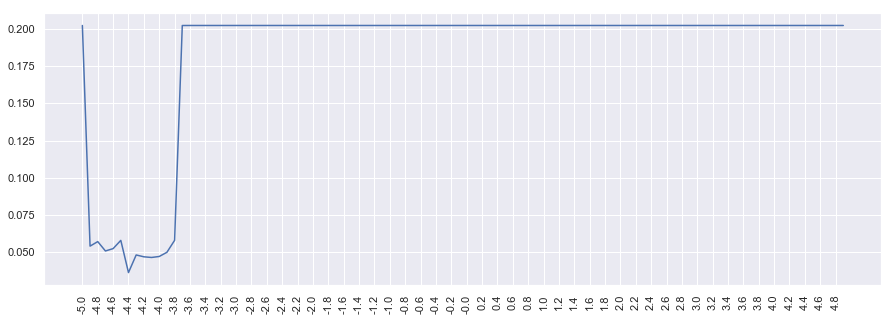

In [7]:
nn = NN(X, y, [50, 100])
nn.find_best_bias(nn_epochs=100)

In [9]:
nn.bias_score_df[:5]

,Error,Bias
0,0.036088,-4.4
1,0.046261,-4.1
2,0.046707,-4.2
3,0.046923,-4.0
4,0.047942,-4.3


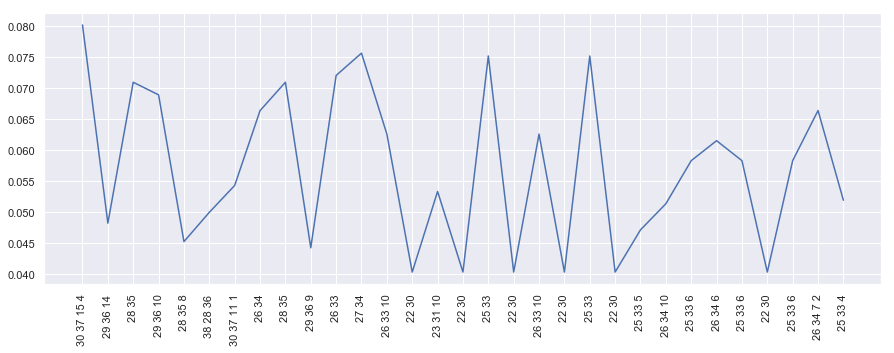

In [10]:
nn = NN(X, y, bias=-4.6)
nn.genetic_alogrithm(10, nn_epochs=200)

In [11]:
df_test = pd.read_csv('./test.csv')
df_test.fillna(0, inplace=True)
df_test = df_test[[c for c in cols if c != 'SalePrice']]
df_test.tail()

X = min_max_scale(df_test)
X

C:\Users\pluketina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.44444444, 0.10430887, 0.2       , ..., 0.        , 0.        ,
        0.09436435],
       [0.55555556, 0.19667235, 0.2       , ..., 0.73529412, 0.        ,
        0.        ],
       [0.44444444, 0.26066553, 0.4       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.44444444, 0.17427474, 0.4       , ..., 0.        , 0.        ,
        0.        ],
       [0.44444444, 0.12009386, 0.        , ..., 0.04117647, 0.5       ,
        0.        ],
       [0.66666667, 0.33980375, 0.6       , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
prediction = (nn1.predict(X) * [ymax-ymin]) + [ymin]
prediction

array([[107255.51211241],
       [132330.86134936],
       [176390.61901332],
       ...,
       [175998.27387376],
       [ 85965.97371758],
       [239216.75398736]])

In [ ]:
df_final = pd.DataFrame(prediction)
df_final['Id'] = df_final.index + 1461
df_final = df_final.rename(columns={0:'SalePrice'})
df_final = df_final[['Id', 'SalePrice']]
df_final.head()

In [ ]:
df_final.to_csv('output.csv', index=False)